In [1]:
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

import qcodes.instrument.parameter as parameter

<IPython.core.display.Javascript object>

In [2]:
def try_close_instruments(instruments=['PulseBlaster', 'ArbStudio', 'SIM900', 'ATS', 'ATS_controller']):
    if isinstance(instruments, str):
        instruments = [instruments]
    for instrument in instruments:
        try:
            eval('{}.close()'.format(instrument_name))
        except:
            pass

In [12]:
import qcodes.instrument_drivers.spincore.PulseBlasterESRPRO as PulseBlaster_driver
import qcodes.instrument_drivers.lecroy.ArbStudio1104 as ArbStudio_driver
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver

for instrument_name in ['PulseBlaster', 'ArbStudio', 'SIM900', 'ATS', 'ATS_controller']:
    try_close_instruments(instrument_name)
    eval('reload({}_driver)'.format(instrument_name))

PulseBlaster = PulseBlaster_driver.PulseBlaster('PulseBlaster')

dll_path = os.path.join(os.getcwd(),'lecroy_driver\\Library\\ArbStudioSDK.dll')
ArbStudio = ArbStudio_driver.ArbStudio1104('ArbStudio', dll_path, server_name=None)

SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
TG, LB, RB, TGAC, SRC, _, DS, DF = [eval('SIM900.chan{}'.format(i)) for i in range(1,9)]

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')

In [13]:
repetition_rate = 0.01

pb_marker_cycles = 100
pb_sampling_rate = 500 # MHz

arb_sampling_rate = 125 # MHz
arb_marker_cycles = 100


In [14]:
# Configure PulseBlaster

pb_cycles = pb_sampling_rate*1e6 * repetition_rate

PulseBlaster.detect_boards()
PulseBlaster.select_board(0)
PulseBlaster.core_clock(pb_sampling_rate)

PulseBlaster.start_programming()
start = PulseBlaster.send_instruction(1,'continue',0,pb_marker_cycles)
PulseBlaster.send_instruction(0, 'branch', start, pb_cycles - pb_marker_cycles)
PulseBlaster.stop_programming()

0

In [15]:
# Configure ArbStudio

ArbStudio.ch3_trigger_mode('stepped')
ArbStudio.ch3_trigger_source('fp_trigger_in')

# Add waveforms
ArbStudio.ch3_clear_waveforms()
ArbStudio.ch3_add_waveform([1]*arb_marker_cycles + [0,0])

#Add sequence
ArbStudio.ch3_sequence([0])

#Load waveforms and sequence
waveforms = ArbStudio.load_waveforms()
sequences = ArbStudio.load_sequence()

In [28]:
# Configure ATS and ATS_controller

ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=135,
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')
ATS_controller.average_mode('trace')
ATS_controller.set_acquisitionkwargs(buffer_timeout=5000,
                                     samples_per_record=50000,
                                     records_per_buffer=1,
                                     buffers_per_acquisition=1,
                                     channel_selection='AB')

In [24]:
ArbStudio.run([3])
PulseBlaster.start()

0

In [30]:
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

dummy_sweep = parameter.ManualParameter(name="dummy")

data = qc.Loop(dummy_sweep[1:5:1], delay=0.003).each(
    ATS_controller.acquisition).run(name='testsweep')

plotQ = qc.QtPlot()
plotQ.add(data.ATS_control_Channel_A_signal)
data.ATS_control_Channel_A_signal

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-08-20/#048_testsweep_11-34-27'
   <Type>   | <array_id>                   | <array.name>     | <array.shape>
   Setpoint | dummy_set                    | dummy            | (4,)
   Measured | index0                       | index0           | (4, 50000)
   Measured | ATS_control_Channel_A_signal | Channel_A_signal | (4, 50000)
   Measured | ATS_control_Channel_B_signal | Channel_B_signal | (4, 50000)
started at 2016-08-20 11:34:35


DataArray[4,50000]: ATS_control_Channel_A_signal
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [23]:
ArbStudio.stop()
PulseBlaster.stop()

0

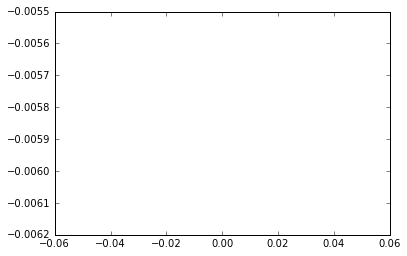

In [21]:
plt.plot(ATS_controller.acquisition())

In [200]:
SIM900.close()

In [5]:
for i in range(1,9):
    print('channel {}: {} V'.format(i, eval('SIM900.chan{}()'.format(i))))

channel 1: 15.54 V
channel 2: 3.8 V
channel 3: 3.8 V
channel 4: 1.675 V
channel 5: 0.25 V
channel 6: 0.0 V
channel 7: 2.646 V
channel 8: 2.646 V
